In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
sns.set(style='whitegrid')

In [8]:
#1. Load training data
input_path = 'data/train.csv'
train_data = pd.read_csv(input_path, index_col='Id')

#1a. Train Data (rows , coulmns)
print("Feature Matrix size : ", train_data.shape)

Feature Matrix size :  (1460, 80)


In [9]:
'''
2. Check if any train_data columns contain missing/NULL values.
If yes, fill missing data appropriately.
'''
null_train_data = train_data.columns[train_data.isnull().any()]
missing_ratio = (train_data[null_train_data].isnull().sum()/len(train_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
missing_data.sort_values(by='Missing Ratio',ascending=False)

,Missing Ratio
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageType,5.55
GarageYrBlt,5.55
GarageFinish,5.55
GarageQual,5.55


In [10]:
'''
3. Fill missing feature values
'''
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    train_data[col] = train_data[col].fillna('None')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType']:
    train_data[col] = train_data[col].fillna('None')
    
for col in ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']:
    train_data[col] = train_data[col].fillna('None')
    
'''
No GarageYrBlt means no Garage. We cannot impute mean/median since it would 
incorrectly convey existence of Garage. same reasoning for MasVnrArea.
'''
for col in ['GarageYrBlt', 'MasVnrArea']:
    train_data[col] = train_data[col].fillna(0)
    
'''
Group data by neighborhood & imputed null LotFrontage columns with median of
grouped data.
'''
train_data['LotFrontage'] = train_data.groupby(['Neighborhood'])\
                    ['LotFrontage'].transform(lambda x : x.fillna(x.median()))

train_data['Electrical'] = \
    train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])
    
null_train_data = train_data.columns[train_data.isnull().any()]
missing_ratio = (train_data[null_train_data].isnull().sum()/len(train_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
print(missing_data.sort_values(by='Missing Ratio',ascending=False))

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [11]:
#4. Fetch Categorical features
cat_features = train_data.select_dtypes(exclude=np.number)
cat_feature_nms = cat_features.columns
print('Number of categorical features : ' + str(cat_feature_nms.size))

Number of categorical features : 43


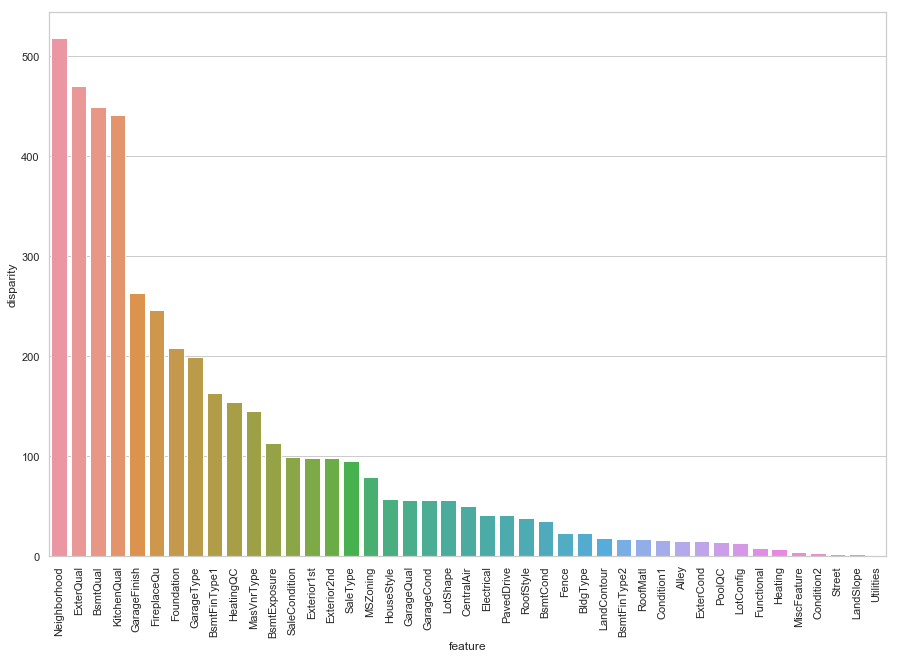

In [12]:
'''
5. Calculate Analysis of Variance (ANOVA) to find correlation 
between categorical features and SalePrice
'''
def anova(data):
    anvova_sig_values = pd.DataFrame()
    anvova_sig_values['feature'] = cat_feature_nms
    pvals = []
    for col in cat_feature_nms:
        col_group_vals = []
        for cls in data[col].unique():
            s = data[data[col] == cls]['SalePrice'].values
            col_group_vals.append(s)
        pval = stats.f_oneway(*col_group_vals)[1]
        pvals.append(pval)
    anvova_sig_values['pval'] = pvals
    return anvova_sig_values.sort_values('pval')

a = anova(train_data)
a['disparity'] = np.log(1./a['pval'].values)
plt.subplots(figsize=(15,10))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [36]:
'''
6. Find multi collinearity between categorical features.
'''
sig_cat_columns = a['feature']
print('Significant columns : ' + str(sig_cat_columns.values))

# Correlation between Significant categorical variables
from itertools import combinations
sig_cat_columns_combo = [combo for combo in combinations(sig_cat_columns, 2)]

def isCorrelated(p):
    if p < 0.05:
        return 'YES'
    else:
        return 'NOT'

p_value_table = pd.DataFrame(index = sig_cat_columns, columns = sig_cat_columns)
from scipy.stats import chi2_contingency
from pandas import crosstab
for (col1, col2) in sig_cat_columns_combo:
    crosstable = crosstab(train_data[col1], train_data[col2])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    p_value_table[col1][col2] = isCorrelated(p)
    
p_value_table

Significant columns : ['Neighborhood' 'ExterQual' 'BsmtQual' 'KitchenQual' 'GarageFinish'
 'FireplaceQu' 'Foundation' 'GarageType' 'BsmtFinType1' 'HeatingQC'
 'MasVnrType' 'BsmtExposure' 'SaleCondition' 'Exterior1st' 'Exterior2nd'
 'SaleType' 'MSZoning' 'HouseStyle' 'GarageQual' 'GarageCond' 'LotShape'
 'CentralAir' 'Electrical' 'PavedDrive' 'RoofStyle' 'BsmtCond' 'Fence'
 'BldgType' 'LandContour' 'BsmtFinType2' 'RoofMatl' 'Condition1' 'Alley'
 'ExterCond' 'PoolQC' 'LotConfig' 'Functional' 'Heating' 'MiscFeature'
 'Condition2' 'Street' 'LandSlope' 'Utilities']


feature,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,FireplaceQu,Foundation,GarageType,BsmtFinType1,HeatingQC,...,ExterCond,PoolQC,LotConfig,Functional,Heating,MiscFeature,Condition2,Street,LandSlope,Utilities
feature,,,,,,,,,,,,,,,,,,,,,
Neighborhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ExterQual,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtQual,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KitchenQual,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageFinish,YES,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FireplaceQu,YES,YES,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Foundation,YES,YES,YES,YES,YES,YES,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageType,YES,YES,YES,YES,YES,YES,YES,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinType1,YES,YES,YES,YES,YES,YES,YES,YES,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
'''
Above matrix confirmed that PoolQC, Heating, MiscFeature, Condition2
are not correlated to Neighborhood.
Lets check if they are coorelated to one another.
'''
sig_cat_columns_short = ['Neighborhood', 'PoolQC', 'Heating', 'MiscFeature', 'Condition2']

sig_cat_columns_combo_short = [combo for combo in combinations(sig_cat_columns_short, 2)]

p_value_table_short = pd.DataFrame(index = sig_cat_columns_short, columns = sig_cat_columns_short)

for (col1, col2) in sig_cat_columns_combo_short:
    crosstable = crosstab(train_data[col1], train_data[col2])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    p_value_table_short[col1][col2] = isCorrelated(p)
    
print(p_value_table_short)

'''
MiscFeature is correlated to PoolQC.
Condition2 is correlated to MiscFeature.
So, lets remove MiscFeature from Model.
Final categorical columns are Neighborhood, PoolQC, Heating, Condition2.
'''

             Neighborhood PoolQC Heating MiscFeature Condition2
Neighborhood          NaN    NaN     NaN         NaN        NaN
PoolQC                NOT    NaN     NaN         NaN        NaN
Heating               NOT    NOT     NaN         NaN        NaN
MiscFeature           NOT    YES     NOT         NaN        NaN
Condition2            NOT    NOT     NOT         YES        NaN


'\nMiscFeature is correlated to PoolQC.\nCondition2 is correlated to MiscFeature.\nSo, lets remove MiscFeature from Model.\nFinal categorical columns are Neighborhood, PoolQC, Heating, Condition2.\n'